<a href="https://colab.research.google.com/github/im-hjk/dankook_dacon/blob/master/DACON_lightgbmcv_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross_Val GBM

## 라이브러리 import 및 설정

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import io
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [ ]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_dkdkdk')
data_dir = main_path / 'data/dacon-dku'
feature_dir = main_path / 'build/feature'
val_dir = main_path / 'build/val'
tst_dir = main_path / 'build/tst'
sub_dir = main_path / 'build/sub'

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [ ]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}_test.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}_test.csv'

In [ ]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.tail()

(400000, 30)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,class,airmass,n_obMde,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,u/g,u/r,u/i,u/z,g/i,g/z,r/i,r/z,i/z,u/_RS,r/_RS
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
399995,18.0627,-0.0003,19.3361,18.3933,18.0860,17.9861,17.9670,-1.0,1.1859,0,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957,-0.4072,-0.4263,0.1190,0.0191,1.0542,1.0768,1.0856,1.0892,1.0298,1.0332,1.0082,1.0115,1.0033,1.9674,1.8271
399996,20.8458,0.0655,21.3993,20.6399,20.5451,20.9507,20.7827,-1.0,1.2850,4,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631,0.3108,0.1428,-0.2376,0.1680,1.0383,1.0444,1.0247,1.0325,0.9868,0.9944,0.9811,0.9886,1.0076,2.1383,2.0475
399997,18.2018,-0.0008,18.9136,17.8753,17.9047,18.0043,18.0400,-1.0,1.1885,0,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618,0.1289,0.1647,-0.1353,-0.0357,1.0635,1.0682,1.0660,1.0658,1.0024,1.0022,0.9980,0.9977,0.9998,1.9401,1.8162
399998,16.5946,0.0428,18.7715,17.4880,17.0557,16.7660,16.5585,-1.0,1.1805,0,-0.1282,-0.1129,-0.0772,-0.0564,-0.0361,-0.7220,-0.9295,0.4972,0.2075,1.0738,1.1031,1.1235,1.1389,1.0463,1.0606,1.0185,1.0324,1.0137,1.8819,1.7060
399999,20.9698,0.0003,20.4958,20.2181,20.3939,20.6696,20.9085,-1.0,1.1832,0,-0.2629,-0.2071,-0.1423,-0.1033,-0.0613,0.4515,0.6904,-0.5146,-0.2389,1.0163,1.0108,0.9993,0.9899,0.9833,0.9740,0.9886,0.9793,0.9906,2.0758,2.0536


In [ ]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 29) (80000, 29)


## Stratified K-Fold Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.877082
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.79756
[3]	valid_0's multi_logloss: 0.722885
[4]	valid_0's multi_logloss: 0.66087
[5]	valid_0's multi_logloss: 0.606319
[6]	valid_0's multi_logloss: 0.559694
[7]	valid_0's multi_logloss: 0.518087
[8]	valid_0's multi_logloss: 0.487539
[9]	valid_0's multi_logloss: 0.454528
[10]	valid_0's multi_logloss: 0.425497
[11]	valid_0's multi_logloss: 0.400839
[12]	valid_0's multi_logloss: 0.382338
[13]	valid_0's multi_logloss: 0.362769
[14]	valid_0's multi_logloss: 0.344104
[15]	valid_0's multi_logloss: 0.327163
[16]	valid_0's multi_logloss: 0.312235
[17]	valid_0's multi_logloss: 0.299845
[18]	valid_0's multi_logloss: 0.28774
[19]	valid_0's multi_logloss: 0.276937
[20]	valid_0's multi_logloss: 0.267192
[21]	valid_0's multi_logloss: 0.25903
[22]	valid_0's multi_logloss: 0.250624
[23]	valid_0's multi_logloss: 0.243657
[24]	valid_0's multi_logloss:

In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3181%


In [ ]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

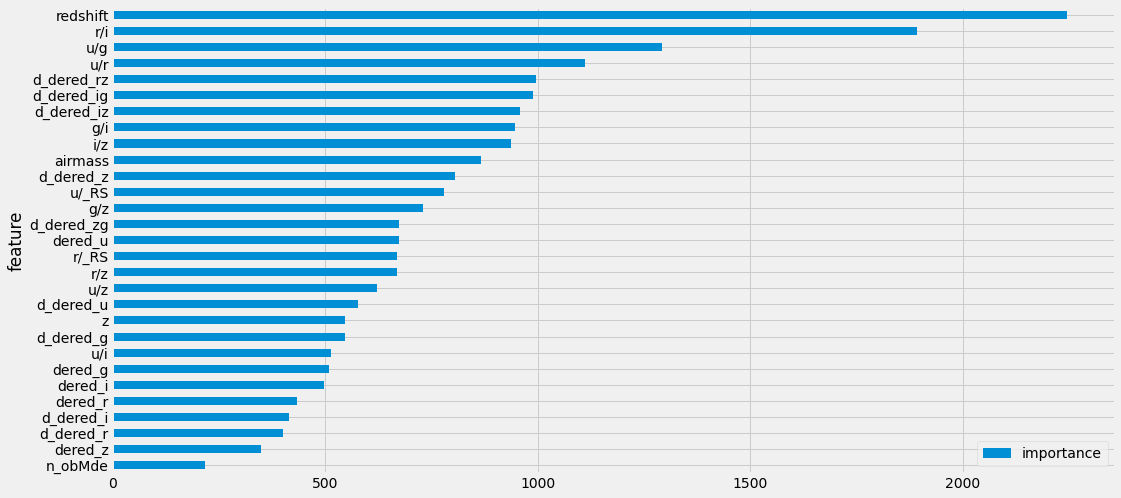

In [ ]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [ ]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [ ]:
sub[target_col].value_counts()

2    40776
0    29986
1     9238
Name: class, dtype: int64

In [ ]:
sub.to_csv(sub_file)